# Load the data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(188318, 132)

# Data transformation

In [10]:
ylog=np.log1p(data_train_raw['loss'])
# ymean=ylog.mean()
# ystd=ylog.std()
ymean=ylog.min()
ystd=ylog.max()
data_train_raw['loss_g']=(ylog-ymean)/ystd

In [11]:
# # clean outliers in training data
# lossMean = data_train_raw['loss_g'].mean()
# lossStd = data_train_raw['loss_g'].std()
# print('Mean of log1py: {}'.format(lossMean))
# print('Std of log1py: {}'.format(lossStd))
# lbound = lossMean-3.0*lossStd
# ubound = lossMean+3.0*lossStd
# print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
# data_train_raw = data_train_raw[(data_train_raw['loss_g']>=lbound) & (data_train_raw['loss_g']<=ubound)]
# print('Shape of cleaned data: {}'.format(data_train_raw.shape))

In [12]:
def ToUniform(y):
    z = norm.cdf(-y/np.sqrt(2))
    return z
def UniformToGauss(z):
    return -np.sqrt(2)*norm.ppf(z)*ystd+ymean
# def BackToOriginal(z):
#     return np.exp(UniformToGauss(z))

data_train_raw['loss_u']=ToUniform(data_train_raw['loss_g'])

def lossRestore(logloss, ymean, ystd):
    loss = np.expm1(logloss*ystd+ymean)
    return loss

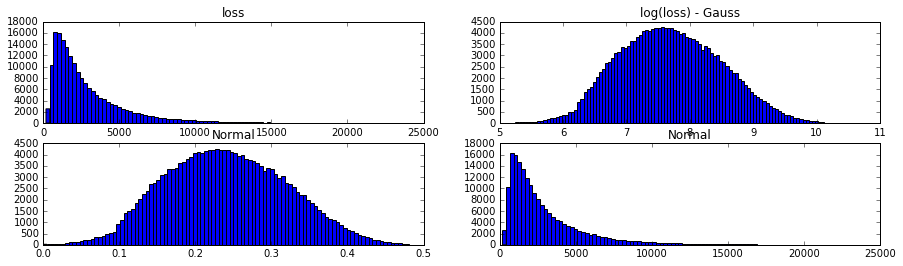

In [13]:
plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
plt.hist(data_train_raw['loss'],100)
plt.title('loss');

plt.subplot(2,2,2)
plt.hist(ylog,100)
plt.title('log(loss) - Gauss');

plt.subplot(2,2,3)
plt.hist(data_train_raw['loss_g'],100)
plt.title('Normal');

plt.subplot(2,2,4)
plt.hist(lossRestore(data_train_raw['loss_g'],ymean,ystd),100)
plt.title('Normal');

# Data preparation - labeling encoder

In [14]:
# save label in a seperate serie
labelSs = data_train_raw['loss_g'] 
trainDf = data_train_raw.drop(['id','loss','loss_g','loss_u'],axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has features from the raw data:\n{}'.format(trainDf.columns))
print('testDf has features from the raw data:\n{}'.format(testDf.columns))

trainDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [15]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313500, 130)
(313500, 116) of which are categorical
(313500, 14) of which are continuous


In [16]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [17]:
LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
def LetterRep(x,LevelList):
    if x in LevelList:
        x = '0'+x
    return x
        
dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0A,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0J,0G,BU,BC,0C,AS,0S,0A,0O,LB
1,0A,0B,0A,0A,0A,0A,0A,0A,0B,0B,...,0K,0K,BI,CQ,0A,AV,BM,0A,0O,DP
2,0A,0B,0A,0A,0B,0A,0A,0A,0B,0B,...,0F,0A,AB,DK,0A,0C,AF,0A,0I,GK
3,0B,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0K,0K,BI,CS,0C,0N,AE,0A,0O,DJ
4,0A,0B,0A,0B,0A,0A,0A,0A,0B,0B,...,0G,0B,0H,0C,0C,0Y,BM,0A,0K,CK


In [18]:
features = dataCatAll.columns[98:]
dataCatAll_2 = dataCatAll[features]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll_2[feat] = pd.factorize(dataCatAll_2[feat], sort=True)[0]
dataCatAll_2.head()
# le.classes_

/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,15,1,6,0,0,8,4,6,9,6,68,49,2,43,17,0,14,300
1,15,11,5,0,0,4,4,8,10,10,56,87,0,46,60,0,14,114
2,1,11,14,0,1,4,5,7,5,0,25,106,0,2,28,0,8,184
3,15,8,3,0,0,4,4,8,10,10,56,89,2,13,27,0,14,108
4,12,5,9,0,0,3,4,10,6,1,7,2,2,24,60,0,10,84


In [19]:
dataCatAll = dataCatAll.drop(features,axis=1)
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98
0,0A,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0A,0A,0A,0A,0D,0B,0C,0E,0A,0C
1,0A,0B,0A,0A,0A,0A,0A,0A,0B,0B,...,0A,0A,0A,0A,0D,0D,0C,0E,0E,0D
2,0A,0B,0A,0A,0B,0A,0A,0A,0B,0B,...,0A,0A,0A,0A,0D,0D,0C,0E,0E,0A
3,0B,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0A,0A,0A,0A,0D,0D,0C,0E,0E,0D
4,0A,0B,0A,0B,0A,0A,0A,0A,0B,0B,...,0A,0A,0B,0H,0D,0B,0D,0E,0E,0A


In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in dataCatAll.columns:
    if (col.find('cat') !=-1):
#        print(col)
        dataCatAll[col]=le.fit_transform(dataCatAll[col])
#         dataAll[col] = dataAll[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
#         le.classes_ = np.append(le.classes_, '<unknown>')
#         data_test_raw[str(col+'_numerical')]=le.transform(data_test_raw[col])
print(dataCatAll.columns)


Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10', u'cat11', u'cat12', u'cat13', u'cat14', u'cat15',
       u'cat16', u'cat17', u'cat18', u'cat19', u'cat20', u'cat21', u'cat22',
       u'cat23', u'cat24', u'cat25', u'cat26', u'cat27', u'cat28', u'cat29',
       u'cat30', u'cat31', u'cat32', u'cat33', u'cat34', u'cat35', u'cat36',
       u'cat37', u'cat38', u'cat39', u'cat40', u'cat41', u'cat42', u'cat43',
       u'cat44', u'cat45', u'cat46', u'cat47', u'cat48', u'cat49', u'cat50',
       u'cat51', u'cat52', u'cat53', u'cat54', u'cat55', u'cat56', u'cat57',
       u'cat58', u'cat59', u'cat60', u'cat61', u'cat62', u'cat63', u'cat64',
       u'cat65', u'cat66', u'cat67', u'cat68', u'cat69', u'cat70', u'cat71',
       u'cat72', u'cat73', u'cat74', u'cat75', u'cat76', u'cat77', u'cat78',
       u'cat79', u'cat80', u'cat81', u'cat82', u'cat83', u'cat84', u'cat85',
       u'cat86', u'cat87', u'cat88', u'cat89', u'cat90', u'cat91', u'cat92'

In [21]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98
0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,3,1,2,4,0,2
1,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,3,3,2,4,4,3
2,0,1,0,0,1,0,0,0,1,1,...,0,0,0,0,3,3,2,4,4,0
3,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,3,3,2,4,4,3
4,0,1,0,1,0,0,0,0,1,1,...,0,0,1,7,3,1,3,4,4,0


In [22]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll_2 = mms.fit_transform(dataCatAll_2)

In [23]:
print(x_catAll_2.shape)
x_catAll_2

(313500, 18)


array([[ 0.9375    ,  0.07142857,  0.33333333, ...,  0.        ,
         0.63636364,  0.86455331],
       [ 0.9375    ,  0.78571429,  0.27777778, ...,  0.        ,
         0.63636364,  0.32853026],
       [ 0.0625    ,  0.78571429,  0.77777778, ...,  0.        ,
         0.36363636,  0.53025937],
       ..., 
       [ 0.9375    ,  0.35714286,  0.27777778, ...,  0.        ,
         0.68181818,  0.93083573],
       [ 0.9375    ,  0.64285714,  0.        , ...,  0.22222222,
         0.63636364,  0.31123919],
       [ 0.75      ,  0.5       ,  0.33333333, ...,  0.        ,
         0.5       ,  0.26224784]])

# restore to x_trainDf and x_testDf - skipped

In [24]:
# # hstack all the features and .
# x_allDf = pd.concat([dataCatAll,dataFltAll],axis=1)
# x_means = x_allDf.mean()
# x_stds = x_allDf.std()
# x_allDf = (x_allDf-x_means)/x_stds
# x_allDf.head()

In [25]:
# x_Train = x_allDf.iloc[0:len(labelSs),:]
# x_Test = x_allDf.iloc[len(labelSs):,:]
# y_Train = labelSs

# one-hot-encoding - skipped in order to keep the alphabetical order

In [26]:
# one-hot-encoding the categorical features
enc = preprocessing.OneHotEncoder()
x_catAll = enc.fit_transform(dataCatAll)
print(x_catAll.shape)

(313500, 275)


# split x_train and x_test

In [27]:
# split x_train and x_test
x_Train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],x_catAll_2[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_Test = sp.sparse.hstack((x_catAll[len(labelSs):,:],x_catAll_2[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_Train = labelSs.values

# check the dimension of prepared data

In [28]:
print(x_Test.shape)
print(x_Train.shape)
print(y_Train.shape)

(125546, 307)
(187954, 307)
(187954,)


# splite the training data for valication

In [29]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_Train, y_Train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(150363, 307)
(150363,)
(37591, 307)
(37591,)


In [30]:
del x_Train
del y_Train
del x_catAll
del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [31]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [32]:
testList = ['XGBoostTrees', 'AdaBoosting', 'MLPRegressor','Ensemble']

### Ridge Regression

In [33]:
# from sklearn.linear_model import RidgeCV
# # from sklearn.linear_model import Ridge

In [34]:
# cv = 3
# # alphas = (1e-2,1e-1,1,1e1,1e2)
# # alphas = (5,20,30,40)
# alphas = [10]
# regCV = RidgeCV(cv=cv,alphas = alphas)
# regCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(regCV.alpha_))
# # print('cv_values_: {}\n'.format(regCV.cv_values_))

In [35]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(regCV.predict(x_val),ymean,ystd)))

In [36]:
# y_pred_i = lossRestore(regCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(regCV.predict(x_val),ymean,ystd))

### Lasso Regression

In [37]:
# from sklearn.linear_model import LassoCV

In [38]:
# cv = 3
# # alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3)
# # alphas = (0.0005,0.0007,0.001,0.003,0.005)
# # alphas = [0.00005,0.0001,0.0003,0.0005]
# alphas = [0.00005]
# LassoCV = LassoCV(cv=cv,alphas = alphas)
# LassoCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(LassoCV.alpha_))

In [39]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(LassoCV.predict(x_val),ymean,ystd)))

In [40]:
# y_pred_i = lossRestore(LassoCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(LassoCV.predict(x_val),ymean,ystd))

### Skipped - Random Forest - using mse rather than mae, because the mae implementation is much slower.

In [41]:
# from sklearn.ensemble import RandomForestRegressor

In [42]:
# criterion = 'mse'
# n_estimators = [30]
# err = 999999999
# n_estimator = 0
# random_state = 0
# for n_est in n_estimators:
#     tmpRFReg = RandomForestRegressor(n_estimators = n_est,criterion = criterion, random_state = random_state)
#     tmpRFReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpRFReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         RFReg = tmpRFReg
#         n_estimator = n_est
#         err = err_i

In [43]:
# print('n_estimator = {}'.format(n_estimator))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(RFReg.predict(x_val),ymean,ystd)))

In [44]:
# y_pred_i = lossRestore(RFReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(RFReg.predict(x_val),ymean,ystd))

### XGBoost Trees

In [45]:
import xgboost as xgb

In [46]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_Test.tocsc())

In [ ]:
num_round = 1500
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':1,'eta':0.155,'min_child_weight':1}# 1132, 75 rounds
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':1,'eta':0.15,'min_child_weight':1}# 1136, 75 rounds
# params = {'eval_metric':'mae','max_depth':12,'colsample_bytree':1,'alpha':1,'gamma':0.01,'eta':0.05,'min_child_weight':1}# 1136, 500 rounds
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0.01,'eta':0.05,'min_child_weight':0}# 1130, 2500 rounds

watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist)

[0]	eval-mae:0.246067	train-mae:0.246598
[1]	eval-mae:0.233767	train-mae:0.234284
[2]	eval-mae:0.222084	train-mae:0.222586
[3]	eval-mae:0.210995	train-mae:0.211482
[4]	eval-mae:0.200467	train-mae:0.200936
[5]	eval-mae:0.190472	train-mae:0.190926
[6]	eval-mae:0.180988	train-mae:0.18143
[7]	eval-mae:0.171998	train-mae:0.172426
[8]	eval-mae:0.163477	train-mae:0.16389
[9]	eval-mae:0.15541	train-mae:0.155805
[10]	eval-mae:0.147779	train-mae:0.148151
[11]	eval-mae:0.140552	train-mae:0.14091
[12]	eval-mae:0.133729	train-mae:0.134068
[13]	eval-mae:0.12729	train-mae:0.127614
[14]	eval-mae:0.121224	train-mae:0.121532
[15]	eval-mae:0.11552	train-mae:0.115805
[16]	eval-mae:0.110167	train-mae:0.110428
[17]	eval-mae:0.105141	train-mae:0.105384
[18]	eval-mae:0.100433	train-mae:0.100656
[19]	eval-mae:0.096029	train-mae:0.096243
[20]	eval-mae:0.091919	train-mae:0.092121
[21]	eval-mae:0.08808	train-mae:0.088282
[22]	eval-mae:0.084509	train-mae:0.084706
[23]	eval-mae:0.081209	train-mae:0.081395
[24]	eval

In [ ]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))

In [ ]:
y_pred_i = lossRestore(gbt.predict(d_test_xgb),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))

### AdaBoost Regression

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

In [ ]:
# n_estimators = [30, 60, 90, 120]
# n_estimators = [10,20,30,40]
n_estimators = [6]
base_estimator = Ridge(alpha = 40)
err = 999999999
n_estimator = 0
random_state = 0
for n_est in n_estimators:
    tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state,base_estimator = base_estimator)
#     tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state)
    tmpAdReg.fit(x_train,y_train)
    err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpAdReg.predict(x_val),ymean,ystd))
    print(err_i)
    if err_i < err:
        AdReg = tmpAdReg
        n_estimator = n_est
        err = err_i

In [ ]:
print('n_estimator = {}'.format(n_estimator))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(AdReg.predict(x_val),ymean,ystd)))

In [ ]:
y_pred_i = lossRestore(AdReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(AdReg.predict(x_val),ymean,ystd))

### Skipped - K Nearest Neighbors

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# n_neighbors = [5, 10, 15]
# weights = 'distance'
# err = 999999999
# n_nns = 0
# # random_state = 0
# for n_nn in n_neighbors:
#     tmpKNReg = KNeighborsRegressor(n_neighbors = n_nn,weights = weights)
#     tmpKNReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpKNReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         KNReg = tmpKNReg
#         n_nns = n_nn
#         err = err_i

In [ ]:
# print('n_neighbors = {}'.format(n_nns))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(KNReg.predict(x_val),ymean,ystd)))

In [ ]:
# y_pred_i = lossRestore(KNReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(KNReg.predict(x_val),ymean,ystd))

### Linear SVR

In [ ]:
# from sklearn.svm import LinearSVR

In [ ]:
# # SVReg = svm.SVR(kernel = 'rbf')
# # SVReg.fit(x_train,y_train)
# SVReg = LinearSVR(C=0.5)
# SVReg.fit(x_train,y_train)

In [ ]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(SVReg.predict(x_val),ymean,ystd)))

In [ ]:
# y_pred_i = lossRestore(SVReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(SVReg.predict(x_val),ymean,ystd))

### MLP Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
MLPReg = MLPRegressor(alpha = 1e-5, hidden_layer_sizes = (35,3),random_state=0,early_stopping=True)
MLPReg.fit(x_train,y_train)

In [ ]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(MLPReg.predict(x_val),ymean,ystd)))

In [ ]:
y_pred_i = lossRestore(MLPReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(MLPReg.predict(x_val),ymean,ystd))

# save files for submission

In [ ]:
# ensemble the results
y_pred.append(np.ndarray.mean(np.vstack(y_pred).T,axis=1))

# ensembled y_val
print('The loss of the ensembled result:')
y_pred_val_en = np.ndarray.mean(np.vstack(y_pred_val).T,axis=1)
mean_absolute_error(lossRestore(y_val,ymean,ystd),y_pred_val_en)

In [ ]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [ ]:
from sklearn.externals import joblib
joblib.dump([regCV, gbt, AdReg, MLPReg, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_Test]
            ,'../output/models_data_on_raw_features.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

In [ ]:
testList
